##### Loading the Libraries

In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#**2.1 Data Collection**

In [ ]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

filename = "C://Users//neelk//Desktop//Big data//Flickr8k_text//Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [ ]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [ ]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [ ]:
file = open(filename,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


# **2.2 Data Cleaning**



In [ ]:
def clean_descriptions(descriptions):
# prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] =  ' '.join(desc)

clean_descriptions(descriptions)

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [ ]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [ ]:
from collections import Counter
def df_word(filename):
    
    vocabulary = []
    for txt in data.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":ct.keys(),"count":ct.values()})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

dfword = df_word(data)
dfword.head(3)

Vocabulary Size: 8918


,word,count
0,a,62986
1,.,36577
2,in,18974


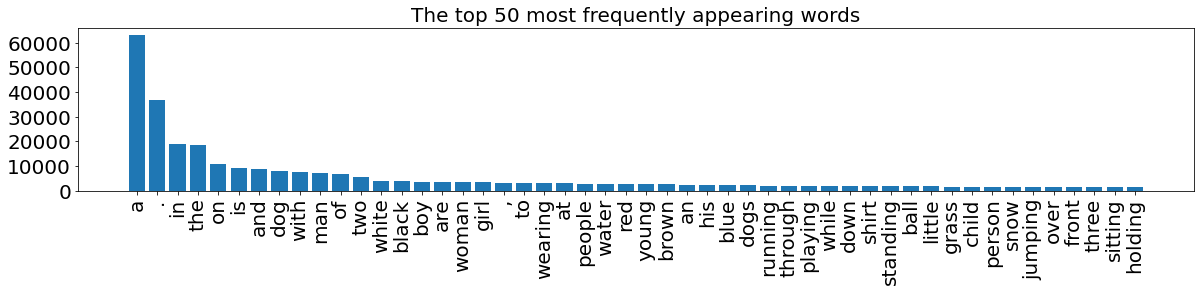

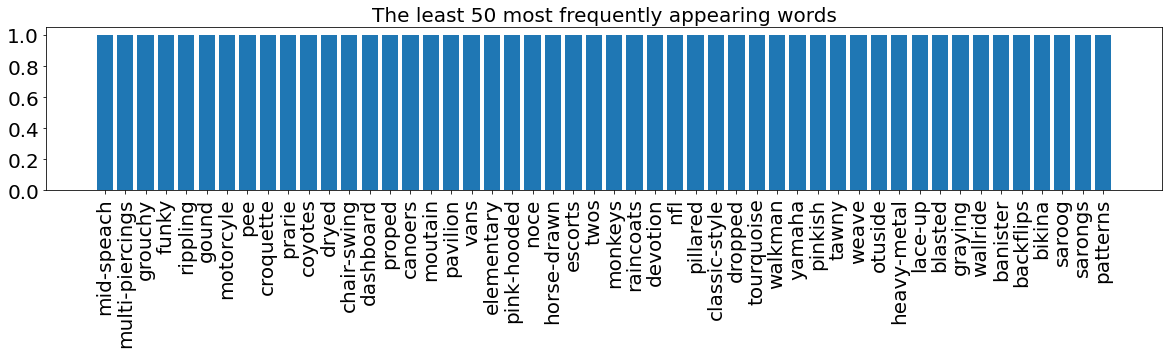

In [ ]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [ ]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

#**2.3 Loading the training dataset**


In [ ]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
   for line in doc.split('\n'):
       if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = 'C:\\Users\\neelk\\Desktop\\Big data\\Flickr8k_text\\Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [ ]:
# Below path contains all the images
images = 'C:\\Users\\neelk\\Desktop\\Big data\\Flickr8k_Dataset\\Flicker8k_Dataset'
img = glob.glob(images + '*.jpg')

In [ ]:
# Below file conatains the names of images to be used in train data
train_images_file = 'C:\\Users\\neelk\\Desktop\\Big data\\Flickr8k_text\\Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
train_img = []

for i in img: 
    if i[len(images):] in train_images: 
        train_img.append(i) 

In [ ]:
test_images_file = 'C:\\Users\\neelk\\Desktop\\Big data\\Flickr8k_text\\Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_img = []

for i in img: 
    if i[len(images):] in test_images: 
        test_img.append(i) 

In [ ]:
def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


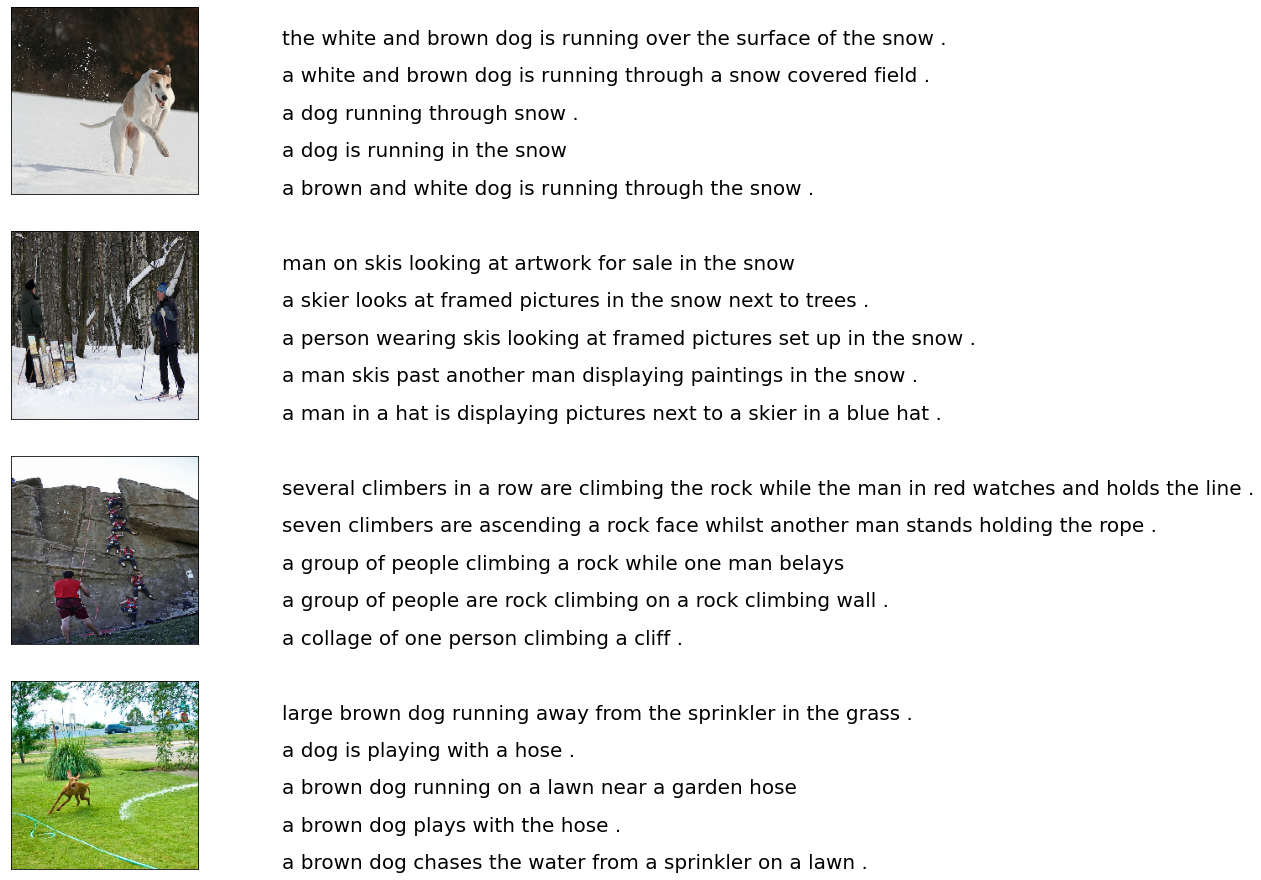

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
    filename = images + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

#**2.4 Data Pre-processing**



##2.4.1 Data Pre-processing of Images

In [ ]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return fea_vec

In [ ]:
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)

In [ ]:
import pickle
with open("C:\\Users\\neelk\\Desktop\\Big data\\encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
# Call the funtion to encode all the test images
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)

In [ ]:
with open("C:\\Users\\neelk\\Desktop\\Big data\\encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [ ]:
train_features = load(open("C:\\Users\\neelk\\Desktop\\Big data\\encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


## 2.4.2 Data Pre-processing of Captions




In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [ ]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [ ]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


# **2.5 Data Preparation using Generator Function**


In [ ]:
X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
    pic = train_features['\\'+ key + '.jpg']
    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)

# **2.6 GloVe Word Embedding Model**


In [ ]:
# load glove vectors for embedding layer
embeddings_index = {}
golve_path ='C:\\Users\\neelk\\.keras\\glove.6B\\glove.6B.200d.txt'
glove = open(golve_path, 'r', encoding = 'utf-8').read()
for line in glove.split("\n"):
    values = line.split(" ")
    word = values[0]
    indices = np.asarray(values[1: ], dtype = 'float32')
    embeddings_index[word] = indices

In [ ]:
emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim))
for word, i in wordtoix.items():
    emb_vec = embeddings_index.get(word)
    if emb_vec is not None:
        emb_matrix[i] = emb_vec
emb_matrix.shape

(1652, 200)

# **2.7 Model Architecture**



In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.2)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, emb_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.2)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.layers[2]

In [ ]:
model.layers[2].set_weights([emb_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
#model.fit([X1, X2], y, epochs = 30, batch_size = 256)
# you can increase the number of epochs for better results

Epoch 1/30
1142/1142 [==============================] - 605s 526ms/step - loss: 4.4714
Epoch 2/30
1142/1142 [==============================] - 599s 524ms/step - loss: 3.2055
Epoch 3/30
1142/1142 [==============================] - 604s 529ms/step - loss: 2.9160
Epoch 4/30
1142/1142 [==============================] - 610s 534ms/step - loss: 2.7446
Epoch 5/30
1142/1142 [==============================] - 606s 531ms/step - loss: 2.6177
Epoch 6/30
1142/1142 [==============================] - 604s 529ms/step - loss: 2.5188
Epoch 7/30
1142/1142 [==============================] - 600s 526ms/step - loss: 2.4326
Epoch 8/30
1142/1142 [==============================] - 600s 526ms/step - loss: 2.3588
Epoch 9/30
1142/1142 [==============================] - 604s 529ms/step - loss: 2.2930
Epoch 10/30
1142/1142 [==============================] - 604s 529ms/step - loss: 2.2400
Epoch 11/30
1142/1142 [==============================] - 606s 531ms/step - loss: 2.1873
Epoch 12/30
1142/1142 [==================

In [ ]:
#model.save_weights('C:\\Users\\neelk\\Desktop\\Big data\\model.h5')

In [ ]:
model.load_weights('C:\\Users\\neelk\\Desktop\\Big data\\model.h5')

In [ ]:
images = 'C:\\Users\\neelk\\Desktop\\Big data\\Flickr8k_Dataset\\Flicker8k_Dataset\\'

In [ ]:
with open("C:\\Users\\neelk\\Desktop\\Big data\\encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

#**3. Results**

In [ ]:
filename = 'C:\\Users\\neelk\\Desktop\\Big data\\Flickr8k_text\\Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

Dataset: 1000


In [ ]:
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

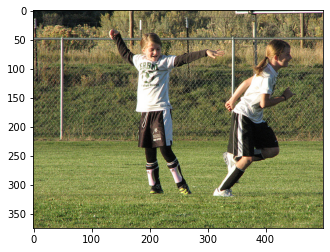

Greedy: two boys playing soccer on the grass
Corpus Bleu Score :  0.47802015283530075


In [ ]:
z=500
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
pred_desc = greedySearch(image)
seq = 'startseq ' +pred_desc + ' endseq'
hypothesis = seq.split(' ')
hypothesis = [hypothesis]
pic_name = pic[1:-4]
print("Greedy:", pred_desc)

reference = []
reference2 = []
for key ,desc in test_descriptions.items():
    if key == pic_name:
         reference.append(desc)
[reference] = reference
reference = [i.split() for i in reference]
reference2.append(reference)

from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu
smoothie = SmoothingFunction().method4
score = corpus_bleu(reference2, hypothesis, smoothing_function = smoothie)
print("Corpus Bleu Score : ", score)

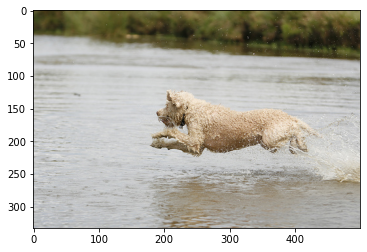

Greedy: dog is running through water
Corpus Bleu Score :  0.8593481942920109


In [ ]:
z=864
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
pred_desc = greedySearch(image)
seq = 'startseq ' +pred_desc + ' endseq'
hypothesis = seq.split(' ')
hypothesis = [hypothesis]
pic_name = pic[1:-4]
print("Greedy:", pred_desc)

reference = []
reference2 = []
for key ,desc in test_descriptions.items():
    if key == pic_name:
         reference.append(desc)
[reference] = reference
reference = [i.split() for i in reference]
reference2.append(reference)

from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu
smoothie = SmoothingFunction().method4
score = corpus_bleu(reference2, hypothesis, smoothing_function = smoothie)
print("Corpus Bleu Score : ", score)

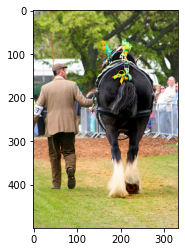

Greedy: horse jumps over hurdle
Corpus Bleu Score :  0.8189819874404609


In [ ]:
z=175
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
pred_desc = greedySearch(image)
seq = 'startseq ' +pred_desc + ' endseq'
hypothesis = seq.split(' ')
hypothesis = [hypothesis]
pic_name = pic[1:-4]
print("Greedy:", pred_desc)

reference = []
reference2 = []
for key ,desc in test_descriptions.items():
    if key == pic_name:
         reference.append(desc)
[reference] = reference
reference = [i.split() for i in reference]
reference2.append(reference)

from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu
smoothie = SmoothingFunction().method4
score = corpus_bleu(reference2, hypothesis, smoothing_function = smoothie)
print("Corpus Bleu Score : ", score)

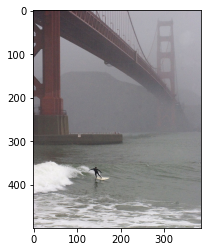

Greedy: the man is swimming underwater
Corpus Bleu Score :  0.703032765073537


In [ ]:
z=107
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
pred_desc = greedySearch(image)
seq = 'startseq ' +pred_desc + ' endseq'
hypothesis = seq.split(' ')
hypothesis = [hypothesis]
pic_name = pic[1:-4]
print("Greedy:", pred_desc)

reference = []
reference2 = []
for key ,desc in test_descriptions.items():
    if key == pic_name:
         reference.append(desc)
[reference] = reference
reference = [i.split() for i in reference]
reference2.append(reference)

from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu
smoothie = SmoothingFunction().method4
score = corpus_bleu(reference2, hypothesis, smoothing_function = smoothie)
print("Corpus Bleu Score : ", score)

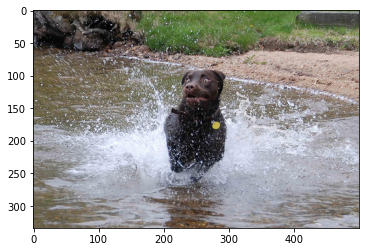

Greedy: dog is running through water
Corpus Bleu Score :  0.7952707287670506


In [ ]:
z=718
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
pred_desc = greedySearch(image)
seq = 'startseq ' +pred_desc + ' endseq'
hypothesis = seq.split(' ')
hypothesis = [hypothesis]
pic_name = pic[1:-4]
print("Greedy:", pred_desc)

reference = []
reference2 = []
for key ,desc in test_descriptions.items():
    if key == pic_name:
         reference.append(desc)
[reference] = reference
reference = [i.split() for i in reference]
reference2.append(reference)

from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu
smoothie = SmoothingFunction().method4
score = corpus_bleu(reference2, hypothesis, smoothing_function = smoothie)
print("Corpus Bleu Score : ", score)

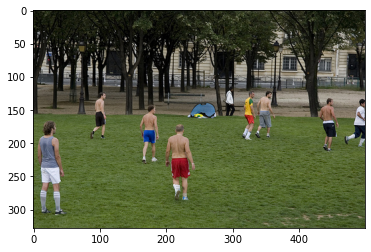

Greedy: two children play on the grass
Corpus Bleu Score :  0.700794872840245


In [ ]:
z=813
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
pred_desc = greedySearch(image)
seq = 'startseq ' +pred_desc + ' endseq'
hypothesis = seq.split(' ')
hypothesis = [hypothesis]
pic_name = pic[1:-4]
print("Greedy:", pred_desc)

reference = []
reference2 = []
for key ,desc in test_descriptions.items():
    if key == pic_name:
         reference.append(desc)
[reference] = reference
reference = [i.split() for i in reference]
reference2.append(reference)

from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu
smoothie = SmoothingFunction().method4
score = corpus_bleu(reference2, hypothesis, smoothing_function = smoothie)
print("Corpus Bleu Score : ", score)

In [ ]:
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu
smoothie = SmoothingFunction().method4
TotalScore = 0

for z in range(1,1000):
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,2048))
    pred_desc = greedySearch(image)
    seq = 'startseq ' +pred_desc + ' endseq'
    hypothesis = seq.split(' ')
    hypothesis = [hypothesis]
    pic_name = pic[1:-4]
    reference = []
    reference2 = []
    for key ,desc in test_descriptions.items():
        if key == pic_name:
            reference.append(desc)
    [reference] = reference
    reference = [i.split() for i in reference]
    reference2.append(reference)
    score = corpus_bleu(reference2, hypothesis, smoothing_function = smoothie)
    TotalScore = TotalScore + score

In [ ]:
AvgScore = TotalScore / 1000
RoundScore = round(AvgScore, 4)
print("Average corpus_BLEU score of model is : ", RoundScore)

Average corpus_BLEU score of model is :  0.4227
